# FINE TUNING BERT

In [ ]:
#Import Libraries
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import plotly.express as px

import seaborn as sns
import time
from IPython.display import clear_output

import nltk
from nltk.corpus import stopwords

import tensorflow as tf
import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm

from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

# READING DATASET

In [ ]:
# loading dataset
df = pd.read_csv('Tweets.csv')
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

# LABEL CHECK

In [ ]:
df['airline_sentiment']

,airline_sentiment
0,neutral
1,positive
2,neutral
3,negative
4,negative
...,...
14635,positive
14636,negative
14637,neutral
14638,negative


# FEATURES AND THEIR TYPES

In [ ]:
for col in df.columns:
  print(f"COLUMN: {col}, TYPE: {df[col].dtype}")

COLUMN: tweet_id, TYPE: int64
COLUMN: airline_sentiment, TYPE: object
COLUMN: airline_sentiment_confidence, TYPE: float64
COLUMN: negativereason, TYPE: object
COLUMN: negativereason_confidence, TYPE: float64
COLUMN: airline, TYPE: object
COLUMN: airline_sentiment_gold, TYPE: object
COLUMN: name, TYPE: object
COLUMN: negativereason_gold, TYPE: object
COLUMN: retweet_count, TYPE: int64
COLUMN: text, TYPE: object
COLUMN: tweet_coord, TYPE: object
COLUMN: tweet_created, TYPE: object
COLUMN: tweet_location, TYPE: object
COLUMN: user_timezone, TYPE: object


# DROPPING UNNECESSARY COLUMNS

In [ ]:
df = df.drop(['tweet_id', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence',
              'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count',
              'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone'], axis=1)

In [ ]:
df.columns

Index(['airline_sentiment', 'text'], dtype='object')

# DATA PREPROCESSING

### MAPPING LABEL

In [ ]:
# Map sentiments to numerical labels
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['airline_sentiment'] = df['airline_sentiment'].map(sentiment_mapping)

### CHECKING CLASS BALANCE

In [ ]:
print(df['airline_sentiment'].value_counts())

airline_sentiment
0    9178
1    3099
2    2363
Name: count, dtype: int64


## To Lower Case

In [ ]:
# Lowercase
df['text'].str.lower()

,text
0,@virginamerica what @dhepburn said.
1,@virginamerica plus you've added commercials t...
2,@virginamerica i didn't today... must mean i n...
3,@virginamerica it's really aggressive to blast...
4,@virginamerica and it's a really big bad thing...
...,...
14635,@americanair thank you we got on a different f...
14636,@americanair leaving over 20 minutes late flig...
14637,@americanair please bring american airlines to...
14638,"@americanair you have my money, you change my ..."


In [ ]:
# remove Html tags and special characters
import re
def remove_html_tags(text):
    return re.sub(r'<[^<]+?>', '', text)

df['text'] = df['text'].apply(remove_html_tags)

In [ ]:
# remove URLs
def remove_url(text):
    return re.sub(r'http[s]?://\S+|www\.\S+', '', text)
df['text'] = df['text'].apply(remove_url)

In [ ]:
# Text preprocessing
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
df['text']= df['text'].str.lower().replace('[^a-zA-Z0-9\s]', '', regex=True)
#df_transformed['review_body'] = df_transformed['review_body'].str.replace('[^\\w\\s]', '', regex=True)
df['text'] = df['text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))
df['text']=df['text'].str.lower()
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,airline_sentiment,text
0,1,virginamerica dhepburn said
1,2,virginamerica plus youve added commercials exp...
2,1,virginamerica didnt today must mean need take ...
3,0,virginamerica really aggressive blast obnoxiou...
4,0,virginamerica really big bad thing


In [ ]:
df.shape

(14640, 2)

In [ ]:
df['text'][5000]

'southwestair neveryamind paid 450 flight 250 new bag easy business class customers right'

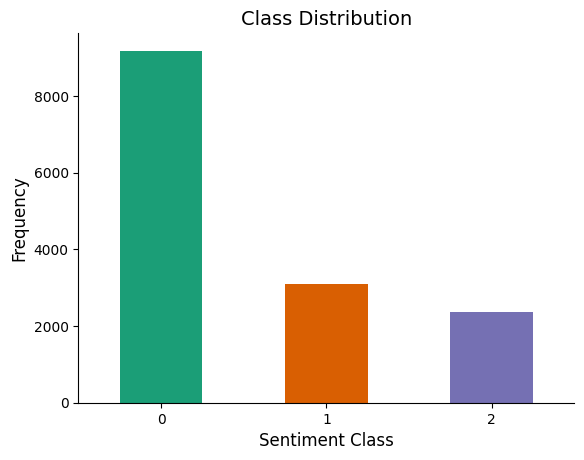

In [ ]:
def plot_class_distribution():
  df.groupby(['airline_sentiment']).size().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'), rot=0)
  plt.title('Class Distribution', fontsize=14)
  plt.xlabel('Sentiment Class', fontsize=12)
  plt.ylabel('Frequency', fontsize=12)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.show()

plot_class_distribution()

# Word Cloud

> It gives frequency of each word. Most frequent appears bigger in font size

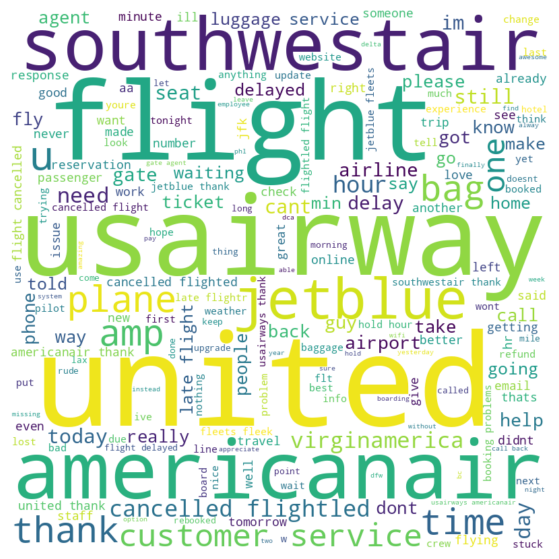

In [ ]:
from wordcloud import WordCloud
from collections import Counter

all_reviews = " ".join(df["text"])

wordcloud = WordCloud(width=800, height=800, background_color='white').generate(all_reviews)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
df_transformed=df.copy()
df_transformed.to_csv('./data_transformed_tweets.csv', index=False)

In [ ]:
df_transformed.head()

,airline_sentiment,text
0,1,virginamerica dhepburn said
1,2,virginamerica plus youve added commercials exp...
2,1,virginamerica didnt today must mean need take ...
3,0,virginamerica really aggressive blast obnoxiou...
4,0,virginamerica really big bad thing


# MODEL TRAINING

In [ ]:
df=pd.read_csv("data_transformed_tweets.csv")
df.head()

,airline_sentiment,text
0,1,virginamerica dhepburn said
1,2,virginamerica plus youve added commercials exp...
2,1,virginamerica didnt today must mean need take ...
3,0,virginamerica really aggressive blast obnoxiou...
4,0,virginamerica really big bad thing


# SENTIMENT ANALYSIS USING DistillBERT

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

### **Explanation of Steps:**

1. **Tokenization:**
   - Converts raw text into tokenized inputs (`input_ids` and `attention_mask`) compatible with the transformer model.
   - Handles padding, truncation, and adds special tokens like `[CLS]` and `[SEP]` to ensure uniform input size.

2. **Feature Mapping:**
   - Prepares tokenized inputs (`input_ids` and `attention_mask`) along with their corresponding labels in the format required for TensorFlow datasets.

3. **Dataset Encoding:**
   - Processes the entire dataset by tokenizing each example and organizing `input_ids`, `attention_mask`, and labels into lists.
   - Converts these lists into a TensorFlow dataset using `tf.data.Dataset.from_tensor_slices` and maps them into a structured format.


In [ ]:
def tokenize_review(review, tokenizer):
    encoded = tokenizer(
        text=review,
        add_special_tokens=True,
        max_length=512,
        padding="max_length",
        truncation=True,
        return_tensors="tf"
    )
    return {
        "input_ids": encoded["input_ids"].numpy()[0],
        "attention_mask": encoded["attention_mask"].numpy()[0]
    }

# Dataset encoding function
def encode_dataset(dataset, tokenizer, limit=-1):
    input_ids_list = []
    attention_mask_list = []
    label_list = []

    if limit > 0:
        dataset = dataset.take(limit)

    for review, label in tfds.as_numpy(dataset):
        tokenized = tokenize_review(review.decode(), tokenizer)
        input_ids_list.append(tokenized['input_ids'])
        attention_mask_list.append(tokenized['attention_mask'])
        label_list.append(label)

    tf_dataset = tf.data.Dataset.from_tensor_slices((
        input_ids_list,
        attention_mask_list,
        label_list
    ))
    return tf_dataset.map(prepare_features)

def prepare_features(input_ids, attention_mask, label):
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask
    }, label

# SPLITTING DATASET

> Ratio

- Train `80%` OR `70%`
- Test `20%` OR `30%`

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['airline_sentiment'],
                                                    test_size=0.3, random_state=42, stratify=df['airline_sentiment'])

# COMPUTING CLASS WEIGHTS

In [ ]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print(f"Computed Class Weights: {class_weights_dict}")

Computed Class Weights: {0: 0.5316731517509727, 1: 1.5749193176579068, 2: 2.065296251511487}


# HYPER PARAMETERS INITIALIZATION

In [ ]:
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 2e-5
EPSILON = 1e-08

# Prepare dataset

In [ ]:
# Prepare TensorFlow datasets
ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

ds_train_encoded = encode_dataset(ds_train, tokenizer).shuffle(10000).batch(BATCH_SIZE)
ds_test_encoded = encode_dataset(ds_test, tokenizer).batch(BATCH_SIZE)

# Initialize and Compile the model

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

optimizer = tf.optimizers.Adam(learning_rate=LEARNING_RATE, epsilon=EPSILON)
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=[metric]
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

# FINE TUNING



In [ ]:
history = model.fit(
    ds_train_encoded,
    validation_data=ds_test_encoded,
    epochs=EPOCHS,
    class_weight=class_weights_dict
)

Epoch 1/3
641/641 [==============================] - 689s 1s/step - loss: 0.1080 - accuracy: 0.9602 - val_loss: 0.8176 - val_accuracy: 0.7908
Epoch 2/3
641/641 [==============================] - 689s 1s/step - loss: 0.0856 - accuracy: 0.9718 - val_loss: 0.8015 - val_accuracy: 0.8126
Epoch 3/3
641/641 [==============================] - 630s 983ms/step - loss: 0.0649 - accuracy: 0.9780 - val_loss: 0.8574 - val_accuracy: 0.7962


# Performance evaluation

In [ ]:
save_path = '/five'
model.save_pretrained(save_path)

test_loss, test_accuracy = model.evaluate(ds_test_encoded)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

275/275 [==============================] - 85s 307ms/step - loss: 0.8574 - accuracy: 0.7962
Test Loss: 0.8574405312538147
Test Accuracy: 0.7962204217910767


# Classification Report

In [ ]:
# Predict on the test dataset
y_pred = []
y_true = []

for inputs, labels in ds_test_encoded:
    logits = model.predict(inputs).logits
    predictions = tf.argmax(logits, axis=-1)
    y_pred.extend(predictions.numpy())
    y_true.extend(labels.numpy())

1/1 [==============================] - 0s 159ms/step


'              precision    recall  f1-score   support\n\n    Negative       0.89      0.86      0.87      2753\n     Neutral       0.61      0.66      0.63       930\n    Positive       0.72      0.73      0.72       709\n\n    accuracy                           0.80      4392\n   macro avg       0.74      0.75      0.74      4392\nweighted avg       0.80      0.80      0.80      4392\n'

In [ ]:
# Generate a classification report
print(classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.89      0.86      0.87      2753
     Neutral       0.61      0.66      0.63       930
    Positive       0.72      0.73      0.72       709

    accuracy                           0.80      4392
   macro avg       0.74      0.75      0.74      4392
weighted avg       0.80      0.80      0.80      4392



275/275 [==============================] - 86s 306ms/step


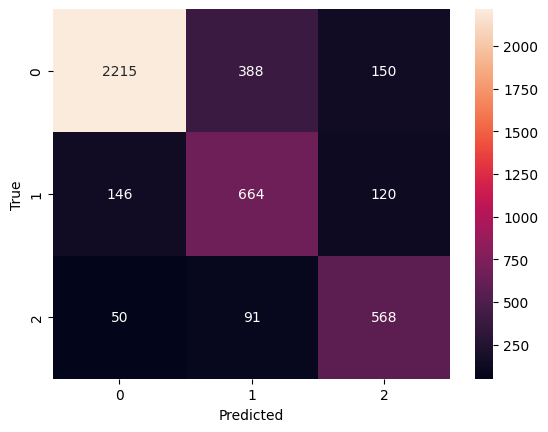

In [ ]:
predictions = model.predict(ds_test_encoded)
predicted_classes = np.argmax(predictions.logits, axis=1)
true_classes = y_test

# Confusion matrix
from sklearn.metrics import confusion_matrix

cm= confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# USING MODEL FOR SENTIMENT ANALYSIS

In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf

model_path = '/content/drive/My Drive/MydistillBERT'
model = TFDistilBertForSequenceClassification.from_pretrained(model_path)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Define sentiment mapping
sentiment_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}

# Function for sentiment analysis
def predict_sentiment(text):
    encoded = tokenizer(
        text,
        add_special_tokens=True,
        max_length=512,
        padding="max_length",
        truncation=True,
        return_tensors="tf"
    )
    predictions = model.predict({
        'input_ids': encoded['input_ids'],
        'attention_mask': encoded['attention_mask']
    }).logits
    predicted_label = tf.argmax(predictions, axis=1).numpy()[0]
    return sentiment_mapping[predicted_label]

while(True):
  user_input = input("Enter a sentence for sentiment analysis (q/e to exit): ")
  if user_input.lower() in ["q", "e", "exit", "quit"]:
    print("GOODBYE")
    break
  result = predict_sentiment(user_input)
  print(f"The sentiment is: {result}")

Some layers from the model checkpoint at /content/drive/My Drive/MydistillBERT were not used when initializing TFDistilBertForSequenceClassification: ['dropout_39']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/My Drive/MydistillBERT and are newly initialized: ['dropout_79']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Enter a sentence for sentiment analysis (q/e to exit): What are you doing?
1/1 [==============================] - 1s 1s/step
The sentiment is: Negative
Enter a sentence for sentiment analysis (q/e to exit): Why are you here?
1/1 [==============================] - 0s 53ms/step
The sentiment is: Negative
Enter a sentence for sentiment analysis (q/e to exit): Lets Go
1/1 [==============================] - 0s 67ms/step
The sentiment is: Positive
Enter a sentence for sentiment analysis (q/e to exit): The flight was good bad
1/1 [==============================] - 0s 57ms/step
The sentiment is: Negative
Enter a sentence for sentiment analysis (q/e to exit): good
1/1 [==============================] - 0s 52ms/step
The sentiment is: Neutral
Enter a sentence for sentiment analysis (q/e to exit): bad
1/1 [==============================] - 0s 58ms/step
The sentiment is: Neutral
Enter a sentence for sentiment analysis (q/e to exit): worst
1/1 [==============================] - 0s 68ms/step
The sent

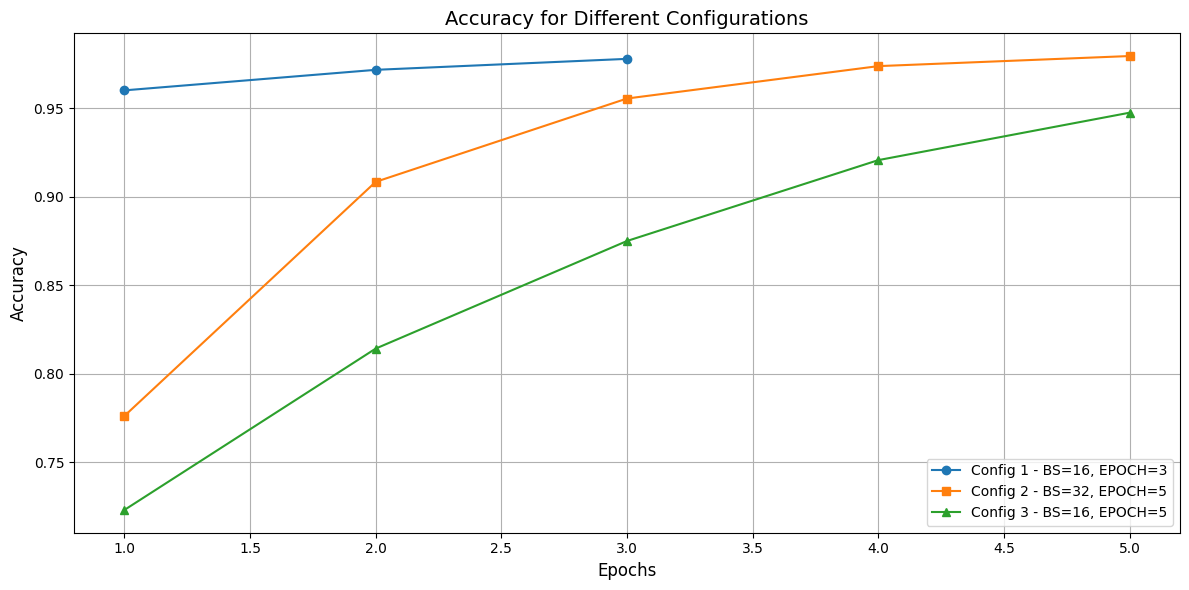

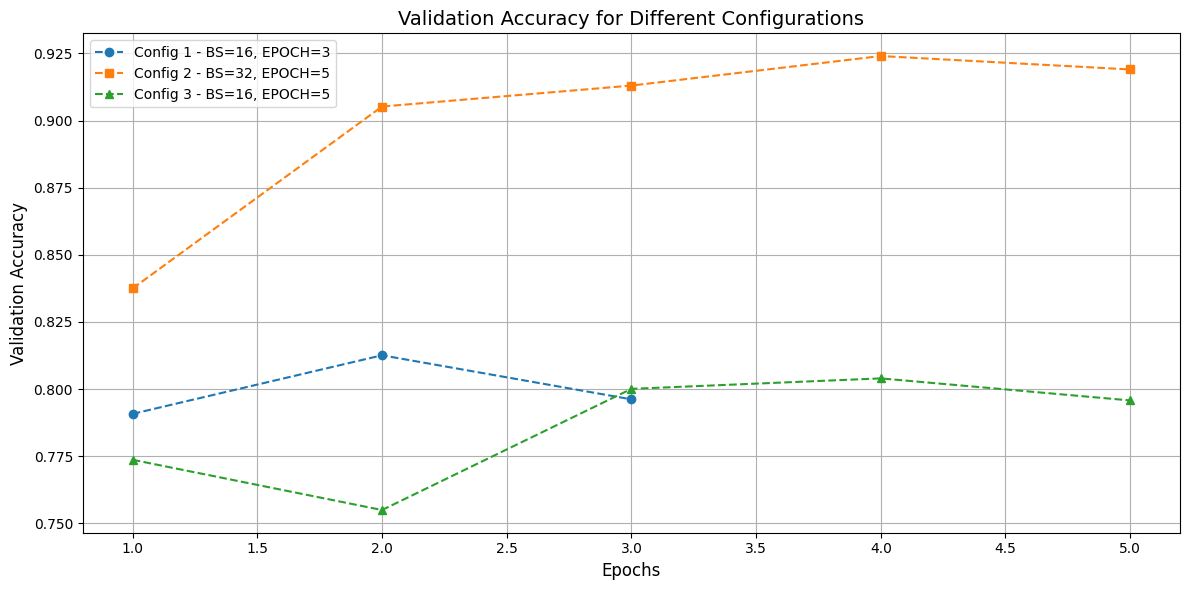

In [ ]:
import matplotlib.pyplot as plt

# Data for plotting
epochs_3 = [1, 2, 3]
epochs_5 = [1, 2, 3, 4, 5]

# Configurations data
config1_acc = [0.9602, 0.9718, 0.9780]
config1_val_acc = [0.7908, 0.8126, 0.7962]

config2_acc = [0.7762, 0.9085, 0.9556, 0.9739, 0.9796]
config2_val_acc = [0.8375, 0.9052, 0.9130, 0.9240, 0.9190]

config3_acc = [0.7231, 0.8143, 0.8751, 0.9208, 0.9476]
config3_val_acc = [0.7737, 0.7550, 0.8001, 0.8040, 0.7958]

# Plotting Accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs_3, config1_acc, marker='o', label='Config 1 - BS=16, EPOCH=3')
plt.plot(epochs_5, config2_acc, marker='s', label='Config 2 - BS=32, EPOCH=5')
plt.plot(epochs_5, config3_acc, marker='^', label='Config 3 - BS=16, EPOCH=5')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy for Different Configurations', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n\n\n\n")

# Plotting Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs_3, config1_val_acc, marker='o', linestyle='--', label='Config 1 - BS=16, EPOCH=3')
plt.plot(epochs_5, config2_val_acc, marker='s', linestyle='--', label='Config 2 - BS=32, EPOCH=5')
plt.plot(epochs_5, config3_val_acc, marker='^', linestyle='--', label='Config 3 - BS=16, EPOCH=5')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('Validation Accuracy for Different Configurations', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
